In [1]:
import jax
import jax.numpy as jnp
import equinox as eqx
import diffrax
import optax
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from tqdm import tqdm # Pour la barre de progression

# --- Paramètres de l'expérience ---
THETA_DIM = 2
X_DIM = 2
HIDDEN_SIZE = 128
DEPTH = 4
BATCH_SIZE = 256
TRAIN_STEPS = 10000
LR = 1e-3
NORM_TYPE = "none" # Essaie "none", "layer", ou "spectral" !

# 1. Génération du dataset Two Moons
def get_dataloader(n_samples=10000, batch_size=256):
    # Génère les données cibles (theta_1)
    theta, _ = make_moons(n_samples=n_samples, noise=0.05)
    # Normalisation standard (moyenne 0, variance 1)
    theta = (theta - theta.mean(axis=0)) / theta.std(axis=0)
    
    # Contexte factice (on génère inconditionnellement pour ce test)
    x = jnp.zeros((n_samples, X_DIM))
    
    # On convertit en tenseurs JAX
    theta = jnp.array(theta)
    x = jnp.array(x)
    
    # Un générateur basique pour les batchs
    for i in range(0, n_samples, batch_size):
        yield theta[i:i+batch_size], x[i:i+batch_size]

Début de l'entraînement (none norm)...


100%|██████████| 10000/10000 [00:26<00:00, 378.41it/s]


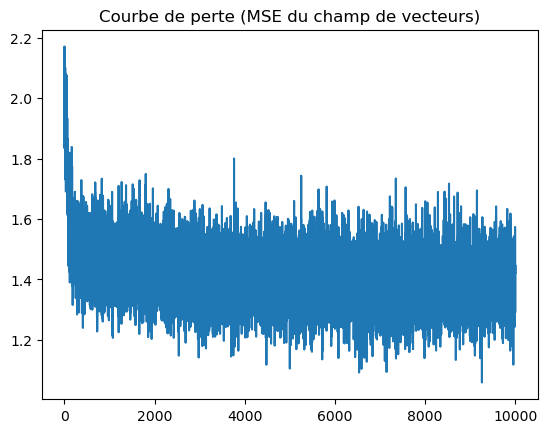

In [2]:
from flow_matching import VectorFieldNetwork, batch_fmpe_loss

# --- Initialisation ---
key = jax.random.PRNGKey(42)
key_model, key_train, key_sample = jax.random.split(key, 3)

model, state = eqx.nn.make_with_state(VectorFieldNetwork)(
    theta_dim=THETA_DIM, 
    x_dim=X_DIM, 
    hidden_size=HIDDEN_SIZE, 
    depth=DEPTH, 
    key=key_model, 
    norm_type=NORM_TYPE
)

optim = optax.adam(learning_rate=LR)
opt_state = optim.init(eqx.filter(model, eqx.is_inexact_array))

# --- Étape d'entraînement ---
@eqx.filter_jit
def make_step(model, state, opt_state, theta_batch, x_batch, step_key):
    def loss_fn(m, s):
        keys = jax.random.split(step_key, theta_batch.shape[0])
        losses, new_state = batch_fmpe_loss(m, s, theta_batch, x_batch, keys, 1e-4, 0.0) # Attention à l'ordre des arguments de batch_fmpe_loss !
        return jnp.mean(losses), new_state

    (loss, new_state), grads = eqx.filter_value_and_grad(loss_fn, has_aux=True)(model, state)
    
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    
    return model, new_state, opt_state, loss

# --- Boucle Principale ---
print(f"Début de l'entraînement ({NORM_TYPE} norm)...")
losses = []

for step in tqdm(range(TRAIN_STEPS)):
    theta_batch, _ = make_moons(n_samples=BATCH_SIZE, noise=0.05)
    theta_batch = (theta_batch - theta_batch.mean(axis=0)) / theta_batch.std(axis=0)
    theta_batch = jnp.array(theta_batch)
    x_batch = jnp.zeros((BATCH_SIZE, X_DIM))
    
    key_train, step_key = jax.random.split(key_train)
    
    model, state, opt_state, loss = make_step(model, state, opt_state, theta_batch, x_batch, step_key)
    losses.append(loss.item())

plt.plot(losses)
plt.title("Courbe de perte (MSE du champ de vecteurs)")
plt.show()

Intégration de l'ODE en cours (ça peut prendre quelques secondes la première fois à cause de la compilation)...


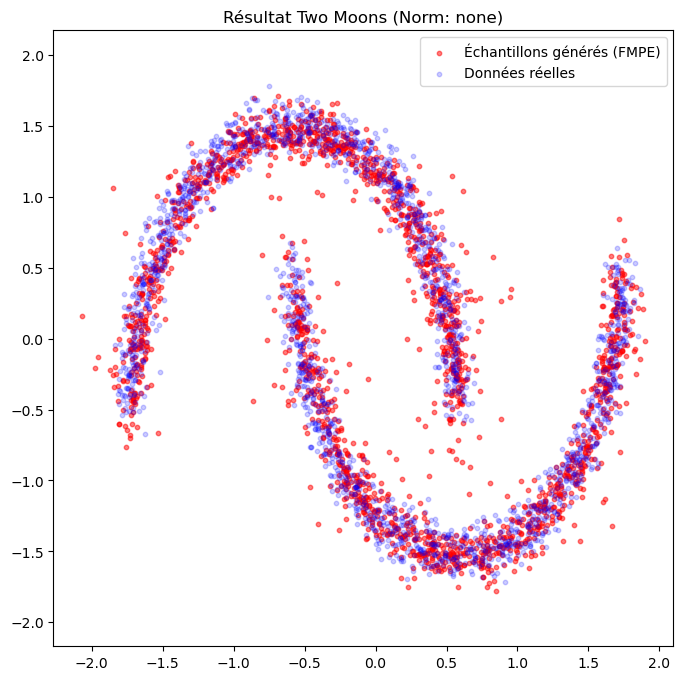

In [3]:
from flow_matching import sample_posterior

# La fonction prend 7 arguments : (model, state, x_obs, key, theta_dim, rtol, atol)
# On veut vectoriser uniquement sur 'key' (la 4ème position, donc l'index 3 qui vaut '0')
batch_sample = eqx.filter_jit(
    eqx.filter_vmap(sample_posterior, in_axes=(None, None, None, 0, None, None, None))
)

# Génération de 2000 échantillons
n_samples = 2000
sample_keys = jax.random.split(key_sample, n_samples)
x_obs_dummy = jnp.zeros(X_DIM) # Le contexte factice

print("Intégration de l'ODE en cours (ça peut prendre quelques secondes la première fois à cause de la compilation)...")

# --- LE CRASH TEST ---
# Test 1 : Avec Dopri5 (Tolérance stricte du papier)
# On n'oublie pas de passer 'state' en 2ème argument !
samples_dopri5 = batch_sample(model, state, x_obs_dummy, sample_keys, THETA_DIM, 1e-7, 1e-7)

# --- Affichage ---
plt.figure(figsize=(8, 8))
plt.scatter(samples_dopri5[:, 0], samples_dopri5[:, 1], alpha=0.5, s=10, color="red", label="Échantillons générés (FMPE)")

# Afficher les vraies données en fond pour comparer
theta_true, _ = make_moons(n_samples=2000, noise=0.05)
theta_true = (theta_true - theta_true.mean(axis=0)) / theta_true.std(axis=0)
plt.scatter(theta_true[:, 0], theta_true[:, 1], alpha=0.2, s=10, color="blue", label="Données réelles")

plt.legend()
plt.title(f"Résultat Two Moons (Norm: {NORM_TYPE})")
plt.axis("equal")
plt.show()